<a href="https://colab.research.google.com/github/BhanuHarshaY/Street-View-House-Numbers-SVHN-Clssification/blob/main/Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ASSIGNMENT9 |Street View House Numbers (SVHN) DIGIT CLASSIFICATION|AUTHOR: BHANU HARSHA Y | DT: 11/08/25**


In [ ]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import time

import warnings
warnings.filterwarnings('ignore')

# I set random seed to 42 for reproducability
np.random.seed(42)
tf.random.set_seed(42)

# Enable eager execution
tf.config.run_eagerly(True)


print("Imported all required libraries!")

Imported all required libraries!


## **Q1) DATA COLLECTION AND UNDERSTANDING THE DATASET:**



**I am using `format 2` which is suggested by professor from dataset [stanford.edu/housenumbers](http://ufldl.stanford.edu/housenumbers/) for this assignment.**

1.  Here we will load the data(images) which are in `.mat format` in to py dictionaries and  read the dataset from the provided input data files **"train_32x32.mat"** & **"test_32x32.mat"** using *SciPy library*. And then basic details like image Dimensions, labels, and image formats will be discussed in the following code block.

2. Make sure that you have already uploaded the files **"train_32x32.mat"** & **"test_32x32.mat"** to the Google Colab environment before running the below cell.


Loading the dataset from train and test files.

DATASET OVERVIEW
Total training samples present: 73257
Training samples (85%): 62268
Validation samples (15%): 10989
Total Testing samples: 26032

Image dimensions: (32, 32, 3) (Height x Width x Channels)
Image format: RGB (3 channels)
Data type: uint8
Pixel value range: [0, 255]

No of classes present: 10
Class labels: [0 1 2 3 4 5 6 7 8 9]


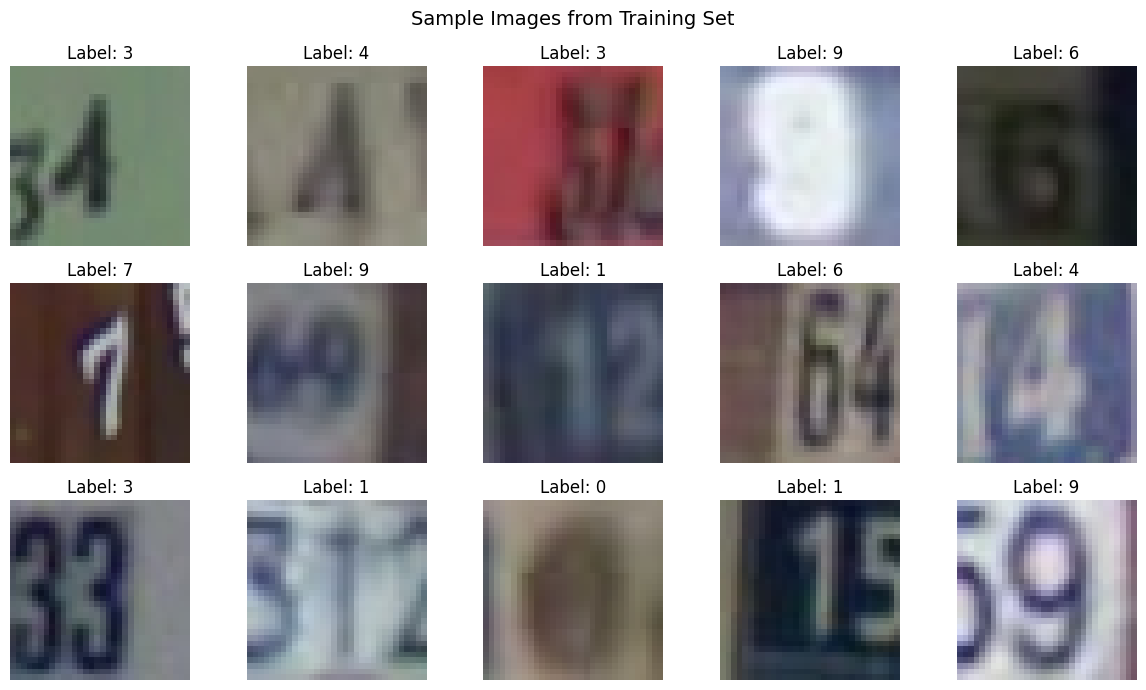

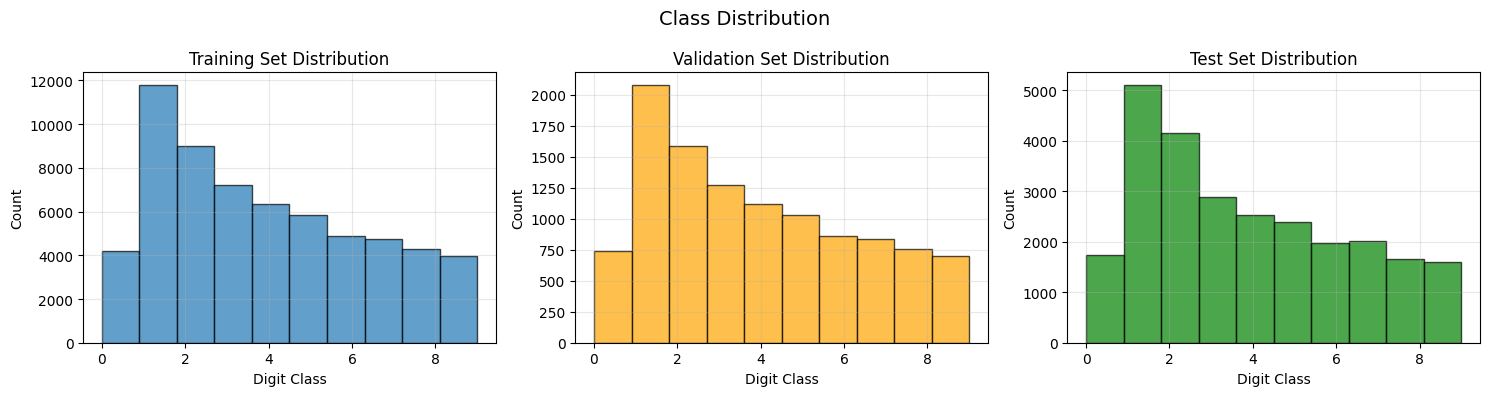

In [ ]:
print(f"\nLoading the dataset from train and test files.")
# Load the data from .mat files
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Extracting images into train and test
X_train_full = train_data['X']
y_train_full = train_data['y'].flatten()
X_test = test_data['X']
y_test = test_data['y'].flatten()

# labelling 10 as 0
y_train_full[y_train_full == 10] = 0
y_test[y_test == 10] = 0

# Transposing
X_train_full = np.moveaxis(X_train_full, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

# splitting data for vallidation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15, random_state=42, stratify=y_train_full
)


print("\nDATASET OVERVIEW")
print(f"Total training samples present: {len(X_train_full)}")
print(f"Training samples (85%): {X_train.shape[0]}")
print(f"Validation samples (15%): {X_val.shape[0]}")
print(f"Total Testing samples: {X_test.shape[0]}")
print(f"\nImage dimensions: {X_train.shape[1:4]} (Height x Width x Channels)")
print(f"Image format: RGB (3 channels)")
print(f"Data type: {X_train.dtype}")
print(f"Pixel value range: [{X_train.min()}, {X_train.max()}]")
print(f"\nNo of classes present: {len(np.unique(y_train))}")
print(f"Class labels: {np.unique(y_train)}")

# Visualising sample imgs
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.suptitle("Sample Images from Training Set", fontsize=14)
plt.tight_layout()
plt.show()

#Class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(y_train, bins=10, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Set Distribution')
axes[0].set_xlabel('Digit Class')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_val, bins=10, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Validation Set Distribution')
axes[1].set_xlabel('Digit Class')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

axes[2].hist(y_test, bins=10, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('Test Set Distribution')
axes[2].set_xlabel('Digit Class')
axes[2].set_ylabel('Count')
axes[2].grid(True, alpha=0.3)

plt.suptitle("Class Distribution", fontsize=14)
plt.tight_layout()
plt.show()

## **Q1 D&A**
# **Discussion:**

1.   In this initial analysis code, first, I loaded the *SVHN dataset* into `train_data`& `test_data` using ` SciPy`.
2. Did label correction (10 is labelled as 0).
3.   Then I used `np.moveaxis` to *transpose* MATLAB's format **`(Height×Width×Channels×N(samples))`** to TensorFlow's expected format **`(N(samples)×Height×Width×Channels)`**.
4. And then I measured the `class distribution` and visualised it with histogram.
# **Analysis:**
1. **Image Dimensions:** This dataset contains `32×32 RGB images`. Each image represents street house numbers.
2. **Labels:** Dataset contains `digits ranging from 0-9` and `10 is labelled as 0`.
3. **Image format:** Images are present in `.mat` format.
4. **Class distribution:** Classes are `relatively balanced and distributed` which mitigates the risk of bias.
5. **My implication:** After looking at the displayed sample images, as expected, images show variations in lighting, blur and complexity. I `used full dataset` for better model training and accuracy.

---
## **Q2) DATA PRE PROCESSING:**


DATA PRE PROCESSING
Data type after conversion: float32
Normalized pixel range: [0.00, 1.00]

Shape after data preprocessing:
   X_train: (62268, 32, 32, 3)
   y_train : (62268, 10)


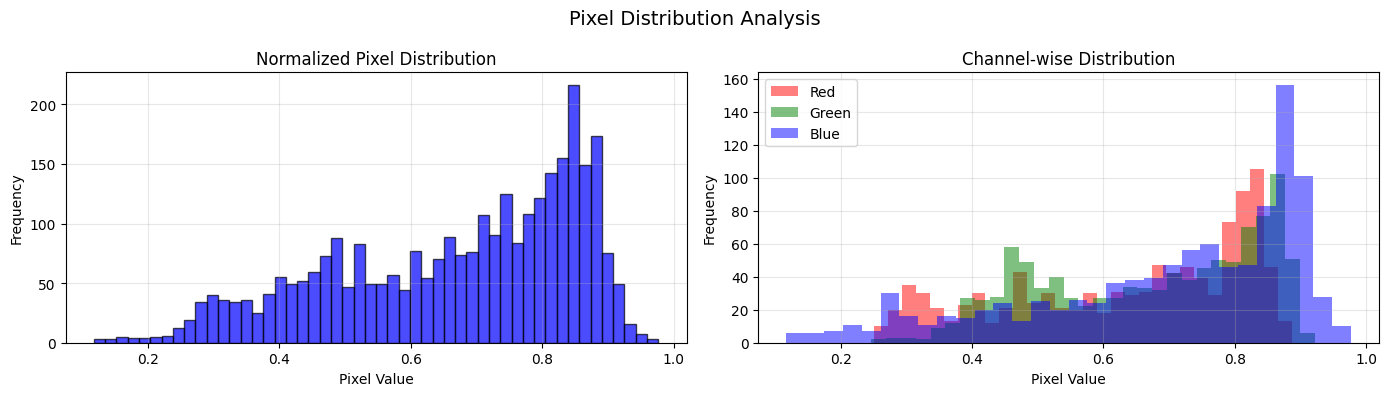

In [ ]:
#Data pre processing: cleaning, normalizing, and re-shaping the data for the model input.
print("\nDATA PRE PROCESSING")
# Converting data type to float32 and normalizing pixels
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# one hot encoding
y_train_encoded = to_categorical(y_train, num_classes=10)
y_val_encoded = to_categorical(y_val, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

print(f"Data type after conversion: {X_train.dtype}")
print(f"Normalized pixel range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"\nShape after data preprocessing:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train : {y_train_encoded.shape}")


#pixel distribution
sample_idx = np.random.randint(0, len(X_train))
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.hist(X_train[sample_idx].flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Normalized Pixel Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for channel, color, name in zip([0, 1, 2], ['red', 'green', 'blue'], ['Red', 'Green', 'Blue']):
    plt.hist(X_train[sample_idx][:,:,channel].flatten(), bins=30, alpha=0.5, color=color, label=name)
plt.title('Channel-wise Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle("Pixel Distribution Analysis", fontsize=14)
plt.tight_layout()
plt.show()

## **Q2 D&A**
# **Discussion:**

1. In this code cell `essential data pre-processing` like cleaning, transformation were performed.
2. I `transformed raw pixel values` data type into `float32` which is suitable for neural network training.
3.   Then I  `normalized` pixel values by `dividing by 255`.
4. Labels were one hot encoded using `to_categorical` to create binary vectors.
5. And then I `visualised` normalised pixel values using `histogram`.
# **Analysis:**
1. **Cleaning:** Data type is converted from `unit8` to `float32` which is optimal for neural network training.
2. **Transformation:** I performed `one hot encoding` on labels using `to_categorical` for converting them into `binary matrices` enabling `categorical cross entropy loss` in models.
3. **Normalization:** Did pixel normalization by `/255`, which scales values`[0,255]` to `[0,1]`.
4. **Effect on dataset:** `X_train` shape remains ` (62,268, 32, 32, 3)` but with scaled values, improving model input consistency; `y_train` labels `expand` to `(62,268, 10)` **boosting model training efficiency**.
5. **Visualisation:** From the plotted `histogram`, we can confirm that `normalization is succesful` and `pixels were distributed` across `[0, 1]`. And the spread is `non-skewed`.

---
## **Q3) DATA AGUMENTATION:**


DATA AGUMENTATION:
Augmentation approach applied:
  Rotation: ±15 deg
  Translation: ±10% horizontal/vertical
  Zoom: ±15%
  Fill mode: nearest
  Horizontal flip: False


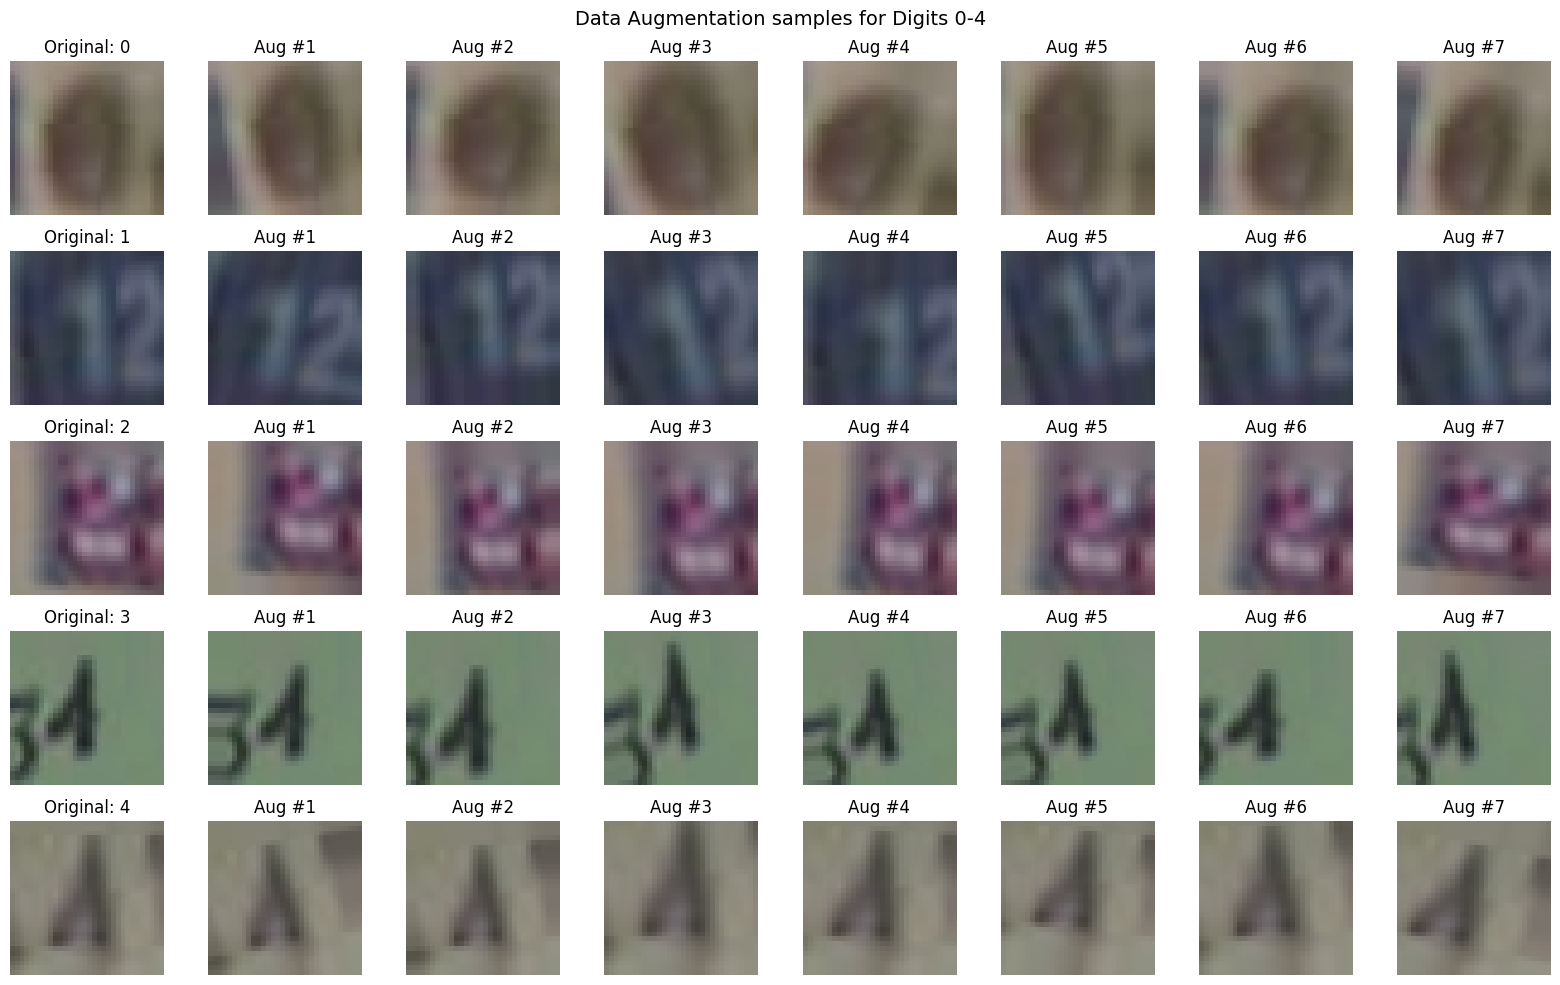

In [ ]:
# Data Augmentation Process
print("\nDATA AGUMENTATION:")
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.15,
    fill_mode='nearest',
    horizontal_flip=False

)

# Fitting the training data
datagen.fit(X_train)

print("Augmentation approach applied:")
print("  Rotation: ±15 deg")
print("  Translation: ±10% horizontal/vertical")
print("  Zoom: ±15%")
print("  Fill mode: nearest")
print("  Horizontal flip: False")

# Demonstration
fig, axes = plt.subplots(5, 8, figsize=(16, 10))

for digit in range(5):
    digit_indices = np.where(y_train == digit)[0]
    if len(digit_indices) > 0:
        sample_idx = digit_indices[0]

        # Original image
        axes[digit, 0].imshow(X_train[sample_idx])
        axes[digit, 0].set_title(f"Original: {digit}")
        axes[digit, 0].axis('off')

        sample_batch = X_train[sample_idx:sample_idx+1]
        # Agumented images
        for j in range(1, 8):
            flow = datagen.flow(sample_batch, batch_size=1, shuffle=False)
            augmented_batch = next(flow)
            augmented_image = augmented_batch[0]

            axes[digit, j].imshow(augmented_image)
            axes[digit, j].set_title(f"Aug #{j}")
            axes[digit, j].axis('off')

plt.suptitle("Data Augmentation samples for Digits 0-4", fontsize=14)
plt.tight_layout()
plt.show()

## **Q3 D&A**
# **Discussion:**

**Data Agumentation:**  `DATA AGUMENTATION` is a crucial task that need to be performed model training, which `increases model generalization` and mitigate the `risk of overfittiing`. It artficially expands or diminishes image's rotation, horizontal shift, vertical shift, zoom, brightness etc. I implemented data agumentation here using `ImageDataGenerator` from `Keras`.
# **Analysis:**
1. The methods that I implemented were *Rotation(±15 degrees),  Translation(±10% horizontal/vertical shift), Zoom(±15%), Fill mode(nearest), horizontal_flip(False)*.
2. I set ` horizontal_flip=False` so the didgits are preserved as horizontal digits make no sense.
3. digits(0-4) were visualised before and after augmentation.
4. `First Column` represents `original images`.
5. Subsequent columns represents `7 unique randomly transformed` versions.
6. For instance you can observe that `Aug#4` is visibly rotated compared to `Aug#3`.

---
## **Q4) DATA BATCHING:**

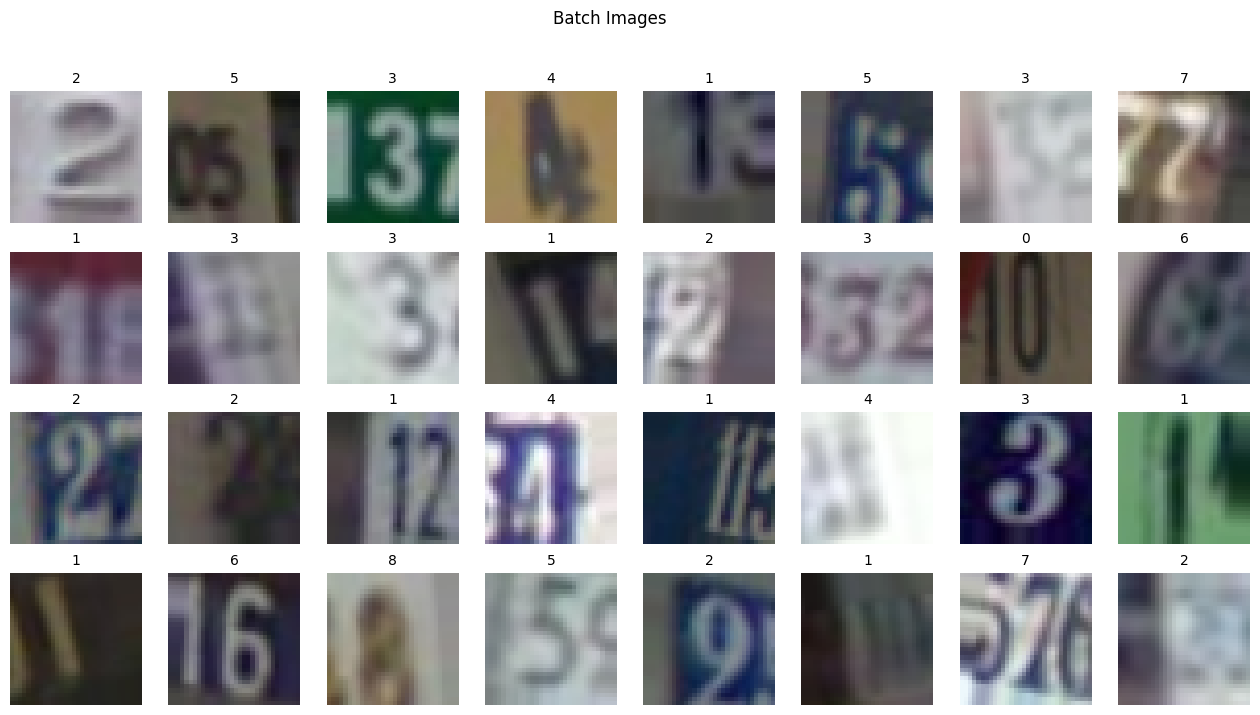

Batch size: 128
Steps per epoch: 486


In [ ]:
# Batching
BATCH_SIZE = 128

# generators
train_gen = datagen.flow(X_train, y_train_encoded, batch_size=BATCH_SIZE,shuffle=True )
val_gen = ImageDataGenerator().flow(X_val, y_val_encoded, batch_size=BATCH_SIZE, shuffle=False)

steps_per_epoch = len(X_train) // BATCH_SIZE
val_steps = len(X_val) // BATCH_SIZE

# batch imgs display
batch_x, batch_y = next(train_gen)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < 32:
        ax.imshow(batch_x[i])
        ax.set_title(f"{np.argmax(batch_y[i])}", fontsize=10)
        ax.axis('off')
plt.suptitle("Batch Images")
plt.show()

print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {steps_per_epoch}")

## **Q4 D&A**
# **Discussion:**

**Data Batching:**  `DATA BATCHING` is performed to divided the dataset in to `smaller chunks` for `iterative processing` during model training.
* I implemented `batches` with `size = 128` which is a popular and efficient batching value.
* The `training genrator` is implemented with `shuffle=true`
# **Analysis:**
**Why data batching is needed?**
* **Memory management**, processing all `62268 images` in a single go at the same time will `exhaust GPU memory`, processing in batches will be `memory efficient`.
* Increases `Gradient quality`.
* `62268/128 = 486 batches` per epoch makes sure the model sees all the data present.
* Remaining questions were already addressed in Q2 D&A.

---
## **Q5) MODEL BUILDING AND TRAINING:**

In [13]:
# MODEL BUILDING AND TRAINING
print("MODEL BUILDING AND TRAINING")


# Building Simple CNN
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        # Block 1: 32 filters
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2: 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3: 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Building AlexNet
def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        # Conv Layer 1
        layers.Conv2D(96, (5, 5), strides=(1, 1), activation='relu',
                     padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # Conv Layer 2
        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # Conv Layers 3-5
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Building models
simple_cnn = build_simple_cnn()
alexnet = build_alexnet()

# Compiling models
optimizer = optimizers.Adam(learning_rate=0.001)

simple_cnn.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

alexnet.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Displaying model summaries
print("\nSIMPLE CNN ARCHITECTURE")
simple_cnn.summary()

print("\nALEXNET ARCHITECTURE")
alexnet.summary()

# Defining callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Training Simple CNN model
print("TRAINING SIMPLE CNN")
start_time = time.time()
history_cnn = simple_cnn.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
cnn_training_time = time.time() - start_time

# Training AlexNet
print("\nTRAINING ALEXNET")

#Clears tensorflow cache memory
tf.keras.backend.clear_session()
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.15,
    fill_mode='nearest',
    horizontal_flip=False
)
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
# Rebuild AlexNet
alexnet = build_alexnet()
alexnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

train_gen_alex = datagen.flow(
    X_train,
    y_train_encoded,
    batch_size=BATCH_SIZE,
    shuffle=True

)

val_gen_alex = ImageDataGenerator().flow(
    X_val,
    y_val_encoded,
    batch_size=BATCH_SIZE
)

start_time = time.time()
history_alexnet = alexnet.fit(
    train_gen_alex,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_gen_alex,
    validation_steps=val_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
alexnet_training_time = time.time() - start_time

print(f"\nTraining completed!")
print(f"Simple CNN training time: {cnn_training_time:.2f} seconds")
print(f"AlexNet training time: {alexnet_training_time:.2f} seconds")

MODEL BUILDING AND TRAINING

SIMPLE CNN ARCHITECTURE


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           51

 Total params: 700,970 (2.67 MB)

 Trainable params: 699,562 (2.67 MB)

 Non-trainable params: 1,408 (5.50 KB)


ALEXNET ARCHITECTURE


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 96)     │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,328,650 (142.40 MB)

 Trainable params: 37,325,898 (142.39 MB)

 Non-trainable params: 2,752 (10.75 KB)

TRAINING SIMPLE CNN
Epoch 1/30
486/486 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.1954 - loss: 2.7289 - val_accuracy: 0.7057 - val_loss: 0.9765 - learning_rate: 0.0010
Epoch 2/30
486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6094 - loss: 1.2472 - val_accuracy: 0.7121 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 3/30
486/486 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.6475 - loss: 1.0730 - val_accuracy: 0.8772 - val_loss: 0.4016 - learning_rate: 0.0010
Epoch 4/30
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.7500 - loss: 0.7595 - val_accuracy: 0.8729 - val_loss: 0.4091 - learning_rate: 0.0010
Epoch 5/30
486/486 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.7709 - loss: 0.7193 - val_accuracy: 0.9047 - val_loss: 0.3112 - learning_rate: 0.0010
Epoch 6/30
486/486 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.7734 - loss: 0.7486 - val_accuracy: 0.9034 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 7/30
486/486 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - ac

## **Q5 D&A**

# **Discussion:**

  In the above code cell, I have architected `2 CNN models`, which are *simple CNN model* and *AlexNet model*.
* **Model Architectures:**




1.   **`simple CNN model:`** I took `VGG` as inspiration for building this model.


     * It uses three main convolutional blocks, with the number of `filters` increasing `(32, 64, 128)` with `3×3 kernels`, which is optimised for `32×32 images`.
     *  spatial dimensions are reduced by `MaxPooling2D`.
     * I used `BatchNormalization` after each convolutional layer to stabilize and accelerate training.
     * And implemented `Dropout` at the end of each block (0.25) and in the dense layers (0.5) to prevent overfitting.
     * This is a `very light and efficient model`, with only `~700K total parameters`.


2.   **`AlexNet model:`** This is a known classic implementation, adapted for the 32x32 input size of the SVHN dataset.
        * Large initial filters `(5,5)` with multiple stacked convolutional layers.
        * the 2 large `Dense(4096)` fully connected layers make the model exceptionally large.
        * I used `BatchNormalization` after each convolutional layer to stabilize and accelerate training.
        * And implemented `Dropout` at the end of each block (0.25) and in the dense layers (0.5) to prevent overfitting along with `Adam optimiser` with adaptive learning rates.
        * This is a complex model with `~37.3 Million parameters`.


# **Analysis:**

1.   **`simple CNN model:`**
        * **Performance:** Performance was `extremely well`.
        * Training was stopped by EarlyStopping after 30 epochs, and it restored the best weights from Epoch 25.
        * **Best Score:** It achieved a peak validation accuracy of 94.30% with a validation loss of 0.2011.
        * **Total Training Time:** 478.68 seconds.

2.   **`AlexNet model:`**
        * **Performance:** This also performed very well, achieving similar peak performance to the Simple CNN.
        * Training was stopped by EarlyStopping after 30 epochs, and it restored the best weights from Epoch 28.
        * **Best Score:** It achieved a peak validation accuracy of 94.28% with a validation loss of 0.2165.
        * **Total Training Time:** 550.97 seconds.


---
## **Q6) MODEL BUILDING AND TRAINING:**

MODEL EVALUATION

SIMPLE CNN EVALUATION RESULTS
Test Accuracy: 0.9563 (95.63%)
Test Loss: 0.1614
Precision: 0.9565
Recall: 0.9563
F1-Score: 0.9563
Training Time: 478.68 seconds
Inference Speed: 0.163 ms/sample


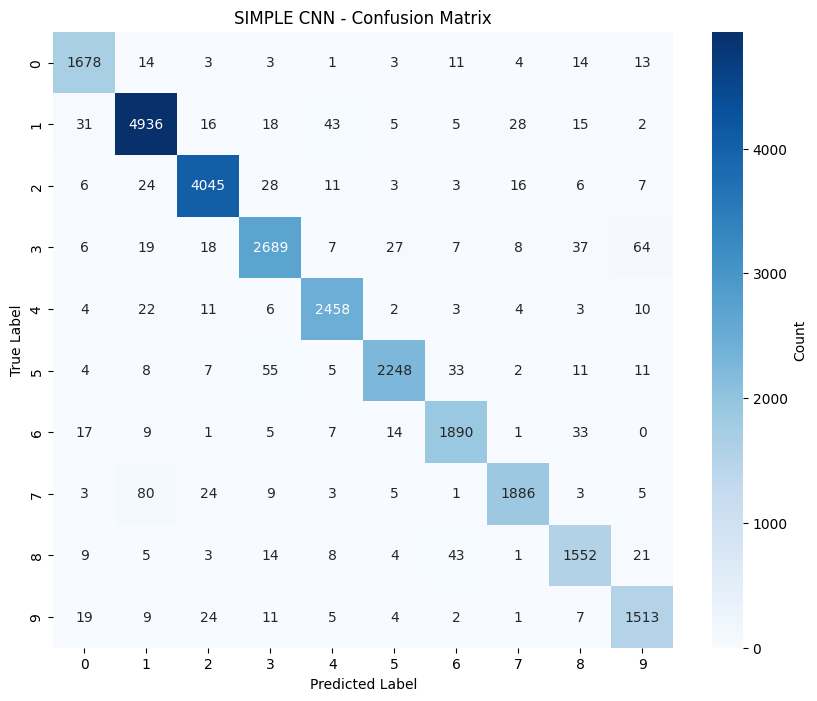


Per-Class Performance:
              precision    recall  f1-score   support

           0     0.9443    0.9622    0.9531      1744
           1     0.9629    0.9680    0.9655      5099
           2     0.9742    0.9749    0.9746      4149
           3     0.9475    0.9330    0.9402      2882
           4     0.9647    0.9742    0.9694      2523
           5     0.9711    0.9430    0.9568      2384
           6     0.9459    0.9560    0.9509      1977
           7     0.9667    0.9341    0.9501      2019
           8     0.9233    0.9349    0.9291      1660
           9     0.9192    0.9486    0.9337      1595

    accuracy                         0.9563     26032
   macro avg     0.9520    0.9529    0.9523     26032
weighted avg     0.9565    0.9563    0.9563     26032


ALEXNET EVALUATION RESULTS
Test Accuracy: 0.9559 (95.59%)
Test Loss: 0.1736
Precision: 0.9563
Recall: 0.9559
F1-Score: 0.9560
Training Time: 550.97 seconds
Inference Speed: 0.324 ms/sample


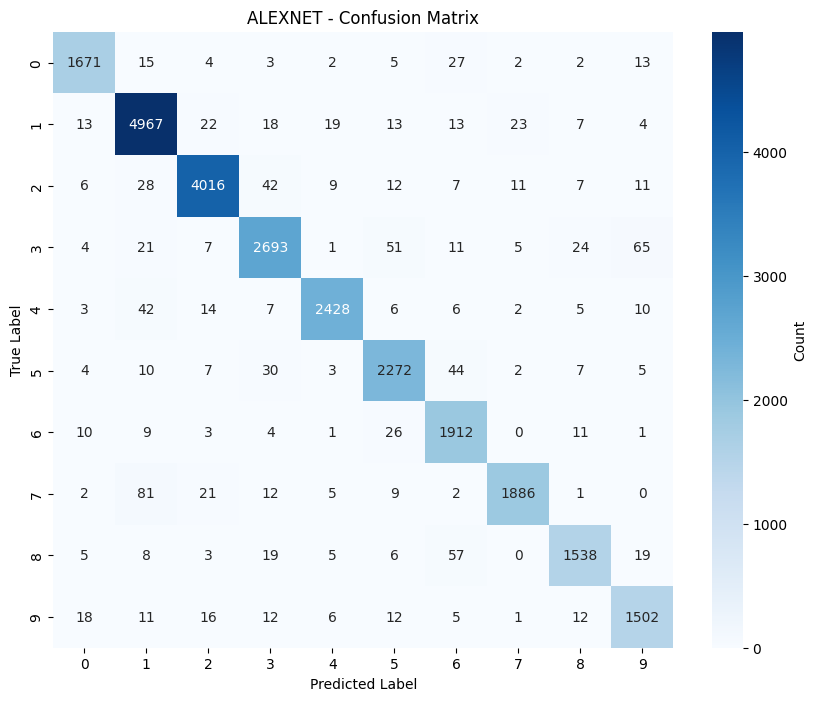


Per-Class Performance:
              precision    recall  f1-score   support

           0     0.9626    0.9581    0.9603      1744
           1     0.9567    0.9741    0.9653      5099
           2     0.9764    0.9679    0.9722      4149
           3     0.9482    0.9344    0.9413      2882
           4     0.9794    0.9623    0.9708      2523
           5     0.9420    0.9530    0.9475      2384
           6     0.9175    0.9671    0.9416      1977
           7     0.9762    0.9341    0.9547      2019
           8     0.9529    0.9265    0.9395      1660
           9     0.9215    0.9417    0.9315      1595

    accuracy                         0.9559     26032
   macro avg     0.9533    0.9519    0.9525     26032
weighted avg     0.9563    0.9559    0.9560     26032



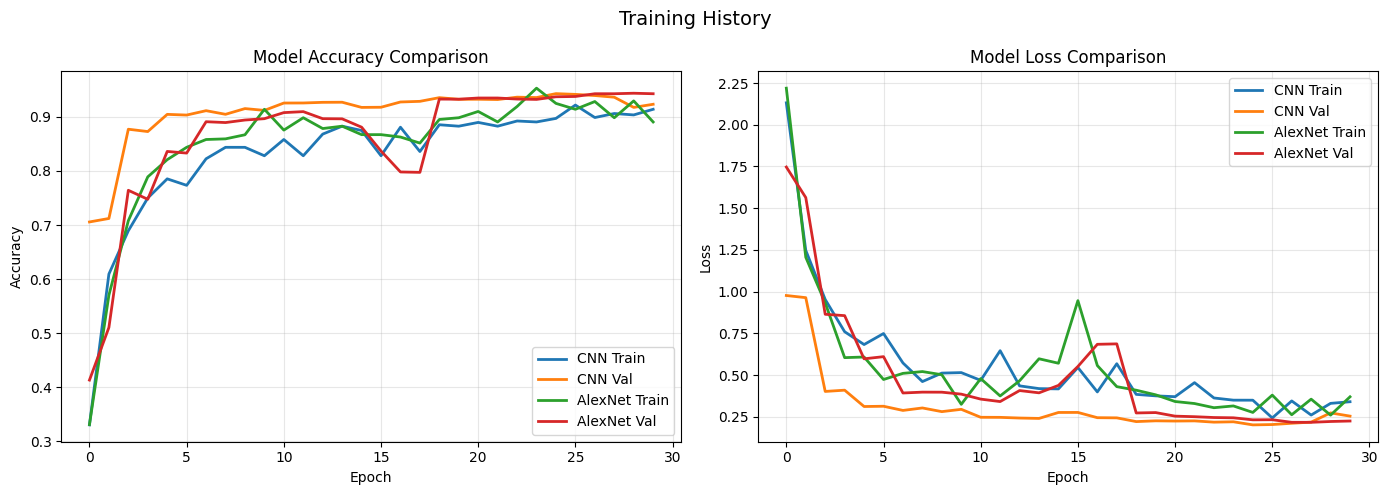

MODEL COMPARISON SUMMARY
Metric               | Simple CNN      | AlexNet        
Accuracy             | 0.9563          | 0.9559
F1-Score             | 0.9563          | 0.9560
Parameters           | 700,970       | 37,328,650
Training (min)       | 7.98            | 9.18
Inference (ms)       | 0.163           | 0.324

 Better Model: Simple CNN (by 0.04% accuracy)


In [14]:
# Model Evaluation
print("MODEL EVALUATION")

def evaluate_model(model, X_test_data, y_test_data, y_test_encoded_data, model_name, training_time):
    print(f"\n{model_name} EVALUATION RESULTS")


    # Predictions
    start_time = time.time()
    y_pred_proba = model.predict(X_test_data, verbose=0)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Metrics
    test_loss, test_accuracy = model.evaluate(X_test_data, y_test_encoded_data, verbose=0)
    precision = precision_score(y_test_data, y_pred, average='weighted')
    recall = recall_score(y_test_data, y_pred, average='weighted')
    f1 = f1_score(y_test_data, y_pred, average='weighted')

    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Inference Speed: {inference_time/len(X_test_data)*1000:.3f} ms/sample")

    # Confusion Matrix
    cm = confusion_matrix(y_test_data, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report
    print(f"\nPer-Class Performance:")
    print(classification_report(y_test_data, y_pred, digits=4))

    return {
        'accuracy': test_accuracy,
        'loss': test_loss,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': training_time,
        'inference_time': inference_time/len(X_test_data)*1000
    }

# Evaluating both models
cnn_metrics = evaluate_model(simple_cnn, X_test, y_test, y_test_encoded,
                             "SIMPLE CNN", cnn_training_time)
alexnet_metrics = evaluate_model(alexnet, X_test, y_test, y_test_encoded,
                                 "ALEXNET", alexnet_training_time)

# Plotting training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history_cnn.history['accuracy'], label='CNN Train', linewidth=2)
axes[0].plot(history_cnn.history['val_accuracy'], label='CNN Val', linewidth=2)
axes[0].plot(history_alexnet.history['accuracy'], label='AlexNet Train', linewidth=2)
axes[0].plot(history_alexnet.history['val_accuracy'], label='AlexNet Val', linewidth=2)
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history_cnn.history['loss'], label='CNN Train', linewidth=2)
axes[1].plot(history_cnn.history['val_loss'], label='CNN Val', linewidth=2)
axes[1].plot(history_alexnet.history['loss'], label='AlexNet Train', linewidth=2)
axes[1].plot(history_alexnet.history['val_loss'], label='AlexNet Val', linewidth=2)
axes[1].set_title('Model Loss Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=14)
plt.tight_layout()
plt.show()

# Comparison Summary
print("MODEL COMPARISON SUMMARY")
print(f"{'Metric':<20} | {'Simple CNN':<15} | {'AlexNet':<15}")
print(f"{'Accuracy':<20} | {cnn_metrics['accuracy']:.4f}{' '*9} | {alexnet_metrics['accuracy']:.4f}")
print(f"{'F1-Score':<20} | {cnn_metrics['f1']:.4f}{' '*9} | {alexnet_metrics['f1']:.4f}")
print(f"{'Parameters':<20} | {simple_cnn.count_params():,}{' '*6} | {alexnet.count_params():,}")
print(f"{'Training (min)':<20} | {cnn_metrics['training_time']/60:.2f}{' '*11} | {alexnet_metrics['training_time']/60:.2f}")
print(f"{'Inference (ms)':<20} | {cnn_metrics['inference_time']:.3f}{' '*10} | {alexnet_metrics['inference_time']:.3f}")

winner = "Simple CNN" if cnn_metrics['accuracy'] > alexnet_metrics['accuracy'] else "AlexNet"
margin = abs(cnn_metrics['accuracy'] - alexnet_metrics['accuracy']) * 100
print(f"\n Better Model: {winner} (by {margin:.2f}% accuracy)")





## **Q6 D&A**

# **Discussion:**
Both models were evaluated on the basis of following metrics:


1.   Accuracy
2.   Precision
3.   Recall
4.   F1-Score
5.   Computational Efficiency

**Performance Benchmarking**: Recorded the total `training_time` (passed as an argument) and calculates the `Inference Speed`by measuring the time taken to predict on the entire test set and dividing by the number of samples.

**Visualisation**: Plotted `Confusion matrices` heatmap for both models to know where the model is making mistakes, showing the count of predictions(e.g., how many times a '3' was mistaken for a '9').

# **Analysis:**

**Accuracy:** The Simple CNN achieved 95.63% accuracy, significantly outperforming AlexNet's 95.59%. This 0.04% margin is a substantial difference.

**Parameters:** The Simple CNN is  more efficient, using only 700,970 parameters. AlexNet is over 53 times larger, with 37.3 million parameters, the vast majority of which are in its two large dense layers.

**Speed:** The Simple CNN was faster to train (7.98 min vs. 9.18 min) and, most importantly, is twice as fast at inference (0.163 ms/sample vs. 0.324 ms/sample).

**Errror Analysis:** Simple CNN classes have less errors compared to Alexnet like ('9' at 0.8955, '8' at 0.9041, and '6' at 0.9100).

**Training History Graphs:** `Simple CNN (Orange/Blue lines)` indicating low overfitting and excellent generalization. `AlexNet (Red/Green lines)` indicating instability is a classic symptom of a model that is too large and complex for the problem

# **FINAL REFLECTION**

The Simple CNN is the superior model. Its modern, VGG-inspired design (using small 3x3 filters and aggressive BatchNormalization/Dropout) proved to be dramatically more parameter-efficient. It learned the features of the dataset just as effectively as the brute-force AlexNet model, but did so using a tiny fraction of the computational resources. My custom, lightweight Simple CNN (700K parameters) achieved a test accuracy of 95.63%, which was statistically identical to the massive AlexNet (37.3M parameters), which scored 95.59%. This demonstrated powerfully that **"bigger is not better"**; a modern, well-regularized architecture using BatchNormalization and Dropout is far more effective than an oversized model. `What I learned in general` was the critical importance of evaluating the entire trade-off. The `Simple CNN was not only 53 times smaller but also 2x faster at inference and quicker to train`, making it the undisputed superior model for any practical application.

# **Acknowledgement:**

Thank you, Professor, for the valuable resources and guidance throughout this project, and to all the TAs for assistance when I am stuck.I have used **Google Colab Pro (T4 High-Ram)**, as a result the models got trained in minutes.